## Question4 Part 3

MLE metrics {'Method': 'MLE', 'Accuracy': 0.979372197309417, 'Precision': 0.9846153846153847, 'Recall': 0.8590604026845637, 'f1 Score': 0.9175627240143369}
MAP metrics for alpha = 1 {'Method': 'MAP (alpha = 0.1)', 'Accuracy': 0.979372197309417, 'Precision': 0.9144736842105263, 'Recall': 0.9328859060402684, 'f1 Score': 0.9235880398671097}
MAP metrics for 0.1 {'Method': 'MAP (alpha = 0.1)', 'Accuracy': 0.9847533632286996, 'Precision': 0.94, 'Recall': 0.9463087248322147, 'f1 Score': 0.9431438127090301}
MAP metrics for 0.5 {'Method': 'MAP (alpha = 0.5)', 'Accuracy': 0.979372197309417, 'Precision': 0.9090909090909091, 'Recall': 0.9395973154362416, 'f1 Score': 0.9240924092409241}
MAP metrics for 5 {'Method': 'MAP (alpha = 5)', 'Accuracy': 0.9704035874439462, 'Precision': 0.9754098360655737, 'Recall': 0.7986577181208053, 'f1 Score': 0.8782287822878229}


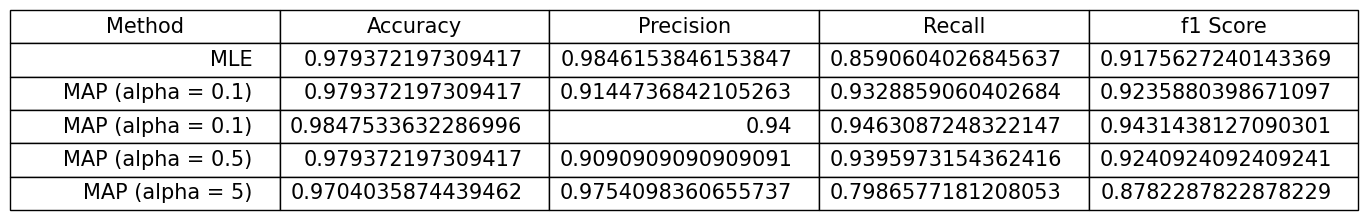

In [ ]:
# Required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from functools import singledispatch #overload function


# Step 1 : Data Loading and Preprocessing
df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['label','message'])
df['label_bin'] = (df['label']=='spam').astype(int)

# lowercase, remove ponctuation and tokenize using CountVectorizer
vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b\w+\b')
X_counts = vectorizer.fit_transform(df['message'])
y = df['label_bin'].values

# split dataset into Train/test sets : 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size=0.2, stratify=y, random_state=0)



#Step 2: Implement Maximum Likelihood Estimator (MLE)
# compute class priors (MLE)
n_train = y_train.shape[0]
pi_mle = y_train.sum() / n_train

# compute word probabilities for each class
def compute_word_probs(X, y, alpha=0.0):
    # X is csr_matrix counts; alpha=0 for MLE; alpha > 0 for Laplace smoothing (MAP)
    n_words = X.shape[1]
    
    # vector of counts
    word_counts_spam = X[y==1].sum(axis=0).A1  
    word_counts_ham  = X[y==0].sum(axis=0).A1
    total_words_spam = word_counts_spam.sum()
    total_words_ham  = word_counts_ham.sum()
    
    # Laplace smoothing for MAP (alpha > 0)
    p_word_given_spam = (word_counts_spam + alpha) / (total_words_spam + alpha*n_words)
    p_word_given_ham  = (word_counts_ham + alpha) / (total_words_ham + alpha*n_words)
    return p_word_given_spam, p_word_given_ham

p_spam_mle, p_ham_mle = compute_word_probs(X_train, y_train, alpha=0.0)  # MLE

# Prediction function using log-prob
def predict_nb(X, p_spam, p_ham, pi):
    log_p_spam = np.log(pi) + X.dot(np.log(p_spam + 1e-12))  # +tiny to avoid log(0)
    log_p_ham  = np.log(1-pi) + X.dot(np.log(p_ham + 1e-12))
    return (log_p_spam > log_p_ham).astype(int)

y_pred_mle = predict_nb(X_test, p_spam_mle, p_ham_mle, pi_mle) # predict


# Evaluation
def evaluate(y_true, y_pred,alpha):
    return {
      'Method' : 'MLE' if alpha == 0 else f'MAP (alpha = {alpha})',
      'Accuracy': accuracy_score(y_true,y_pred),
      'Precision': precision_score(y_true,y_pred),
      'Recall': recall_score(y_true,y_pred),
      'f1 Score': f1_score(y_true,y_pred)
    }

mle_metrics = evaluate(y_test, y_pred_mle,alpha=0.0)
print('MLE metrics', mle_metrics) # MLE Metrics




# Step 3: Implement Maximum A Posteriori (MAP)

# compute word probbability for MAP
# Calling same function but with alpha=1
p_spam_map, p_ham_map = compute_word_probs(X_train, y_train, alpha=1.0)

# predict using MAP probabilites (same pi prior)
y_pred_map = predict_nb(X_test, p_spam_map, p_ham_map, pi_mle)
map_metrics_alpha_1 = evaluate(y_test, y_pred_map,alpha=0.1)

print('MAP metrics for alpha = 1', map_metrics_alpha_1)



# Step 5: Vary the Prior (MAP)

#values of alpha
alphas = [0.1, 0.5, 5]

#initialize performance summary table
performance_metrics = [mle_metrics,map_metrics_alpha_1]

for alpha in alphas:
        
    # compute word probbability for MAP passing alpha
    p_spam_map, p_ham_map = compute_word_probs(X_train, y_train, alpha=alpha)

    # predict using MAP probabilites
    y_pred_map = predict_nb(X_test, p_spam_map, p_ham_map, pi_mle)
    metrics = evaluate(y_test, y_pred_map,alpha=alpha)
    
    #add metrics to performance data
    performance_metrics.append(metrics)
    
    #print metrics
    print(f'MAP metrics for {alpha}', metrics)
    
df = pd.DataFrame(performance_metrics)


# Plot table
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')  # remove axis

# Convert DataFrame to matplotlib table
table = ax.table(
    cellText=df.values,       # table values
    colLabels=df.columns,     # column headers
    loc='center'
)

# Style
table.auto_set_font_size(False)
table.set_fontsize(15)
table.scale(2.9, 2)

plt.show()
    


## Discussion

The results show that MLE has very high precision but relatively low recall, meaning that in predicting spam it tends to miss many true spam messages.

MAP smoothing significantly improves recall because it avoids zero probabilities and reduces overfitting to rare words. We obtain the best overall performance for alpha = 0.1, which provides just enough smoothing to generalize well without overwhelming the true data distribution. 

In addition, larger alpha values (alpha = 5 for example) hurt the performance by generating uniform word probabilities, reducing the accuracy, recall and f1 score. In conclusion, MAP with small smoothing is superior to both MLE and underfits with large priors.

## Question 5 Part 2

a_hat, b_hat: 0.9627124160604003 0.20402004001460927
MSE: 0.22587191853485977 Bias: 0.001309086500561385 Var(pred): 5.012452311187121


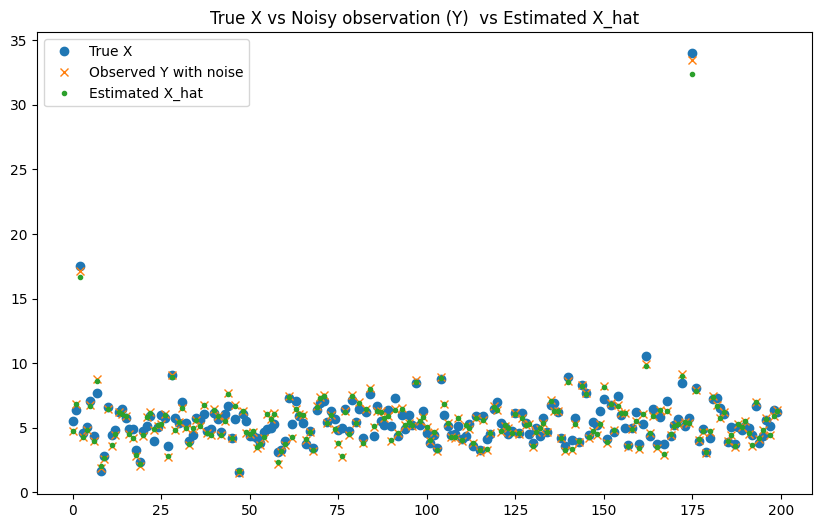

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load California Housing Dataset using sklearn.datasets module
data = fetch_california_housing(as_frame=True)
df = data.frame


# Choose column AveRooms (Average Number of Rooms) in the Dataset
X_true = df['AveRooms'].values.reshape(-1,1)

# Add Gaussian noise to simulate corruption.
rng = np.random.RandomState(0)
noise = rng.normal(0, 0.5, size=X_true.shape[0]) # gaussian noise N ∼ N (0, 0.5^2)
Y_obs = X_true.flatten() + noise # noisy observation

# Split dataset into Train/test split sets (80%,20%)
X_train_true, X_test_true, Y_train_obs, Y_test_obs = train_test_split(
    X_true, Y_obs, test_size=0.2, random_state=0
)


# Downsample 200 points randomly from the test set to reduce clutter in visualizations
idx = np.random.choice(len(X_test_true), size=200, replace=False)


# Fit a LinearRegression model : regress X_true on Y_obs (predict X from Y)
model = LinearRegression() # creating the model
model.fit(Y_train_obs.reshape(-1,1), X_train_true.ravel())  # fit
a_hat = model.coef_[0]
b_hat = model.intercept_

# Predictions on test
X_pred = model.predict(Y_test_obs.reshape(-1,1))

# Computing metrics Metrics:
mse = mean_squared_error(X_test_true, X_pred)
bias_est = np.mean(X_pred) - np.mean(X_test_true)
var_est = np.var(X_pred)
print('a_hat, b_hat:', a_hat, b_hat)
print('MSE:', mse, 'Bias:', bias_est, 'Var(pred):', var_est)

# Visualize the results
plt.figure(figsize=(10,6))
plt.plot(X_test_true[idx], label='True X', marker='o', linestyle='None')
plt.plot(Y_test_obs[idx], label='Observed Y with noise', marker='x', linestyle='None')
plt.plot(X_pred[idx], label='Estimated X_hat', marker='.', linestyle='None')
plt.title('True X vs Noisy observation (Y)  vs Estimated X_hat')
plt.legend(); 


## Discussion

The mean-squared error is MSE=0.2259 which is quite small, indicating that the estimator performs very well and that linear MMSE is effective for this dataset.
The bias is practically zero: Bias(X_hat)=0.00131, which confirms that the linear estimator X_hat is almost an unbiased estimator of the true X, meaning that our model has a good performance.

As in real-world systems, measurements are rarely perfect due to natural conditions or random disturbances, introducing the Gaussian noise reflects the natural imperfections because the Central Limit Theorem implies that many small independent sources of error added behave converge to a normal distribution.  The added noise causes deviations between the observed variable Y and the true value X, producing higher variance and some extreme deviations. In this case, the noise level is relatively low but still reduces accuracy and forces the estimator to shrink large values and lift small ones slightly.

For data integrity, this demonstrates that even modest Gaussian noise introduces uncertainty and requires correction. Therefore, it is important to model noise when training models : ignoring noise measurement errors can lead to biased estimates, while acknowledging them allows more robust and reliable predictions.

Using linear regression (or linear MMSE) assumes a linear relationship between the true value X and the observed noisy value Y. While this assumption is valid for the additive noise model Y=X+N, it does not capture non-linear patterns that may exist between observed features and housing values in other datasets and in such cases, a simple linear estimator may underfit the data, failing to represent complex structures.

More complex models such as polynomial regression, kernel methods, random forests, or neural networks might provide better estimates with non-linear relationships or when noise affect the data in more complex ways (not necessarily additive). 

Eitherway, to choose a model (simple or more advanced), factors such as computational cost, risk of overfitting or underfitting, interpretability and regularization options must always be considered.